In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_deep_learning/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat import v1 as tf_v1
print(tf.version)
tf.compat.v1.disable_eager_execution()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
np.random.seed(0)
tf.random.set_seed(1234)

In [4]:
def Inference(
    x_ph, t_ph, batch_size_ph, is_training_ph,
    input_digits, output_digits, n_hidden, n_out
):
    ### Encoder
    encoder_cell = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    encoder_cell_state = encoder_cell.zero_state(batch_size_ph, tf.float32)
    encoder_cell_outputs = []
    with tf_v1.variable_scope('Encoder'):
        for t in range(input_digits):
            if 0 < t:
                tf_v1.get_variable_scope().reuse_variables()
            encoder_cell_output, encoder_cell_state = encoder_cell(x_ph[:, t, :], encoder_cell_state)
            encoder_cell_outputs.append(encoder_cell_output)

    W_out = tf.Variable(tf.random.truncated_normal([n_hidden, n_out], stddev=0.01))
    b_out = tf.Variable(tf.zeros([n_out], dtype=tf.float32))
    ys = []

    ### Decoder
    decoder_cell = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    decoder_cell_state = encoder_cell_state
    decoder_cell_outputs = [encoder_cell_outputs[-1]]
    with tf_v1.variable_scope('Decoder'):
        for t in range(1, output_digits):
            if 1 < t:
                tf_v1.get_variable_scope().reuse_variables()
            if is_training_ph is True:
                decoder_cell_output, decoder_cell_state = decoder_cell(t_ph[:, t-1, :], decoder_cell_state) ### t_ph[:, t-1, :].shape ---> (None, 12)
            else:
                y = tf.nn.softmax(tf.matmul(decoder_cell_outputs[-1], W_out) + b_out)
                ys.append(y)
                # y_onehot = tf.one_hot(tf.argmax(y, axis=-1), depth=output_digits) ### y_onehot.shape ---> (None, 4)
                y_onehot = tf.one_hot(tf.argmax(y, axis=-1), depth=n_out) ### y_onehot.shape ---> (None, 12)
                decoder_cell_output, decoder_cell_state = decoder_cell(y_onehot, decoder_cell_state)
            decoder_cell_outputs.append(decoder_cell_output)

    if is_training_ph is True:
        sequence_hidden = tf.reshape(tf.concat(decoder_cell_outputs, axis=1), [-1, output_digits, n_hidden])
        sequence_y = tf.nn.softmax(tf.einsum('ijk,kl->ijl', sequence_hidden, W_out) + b_out)
    else:
        y = tf.nn.softmax(tf.matmul(decoder_cell_outputs[-1], W_out) + b_out)
        ys.append(y)
        sequence_y = tf.reshape(tf.concat(ys, axis=1), [-1, output_digits, n_out])
    return sequence_y


def Loss(y, t_ph):
    y_clip = tf.clip_by_value(y, 1.0e-10, 1.0)
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t_ph*tf.math.log(y_clip), axis=1))
    return cross_entropy


def Training(loss):
    optimizer = tf_v1.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step


def Accuracy(y, t_ph):
    correct_pred = tf.equal(tf.argmax(y, axis=-1), tf.argmax(t_ph, axis=-1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy

In [5]:
def RandomNumber(digits):
    number = ''
    random_digits = np.random.randint(1, digits+1)
    for i in range(random_digits):
        number += np.random.choice(list('0123456789'))
    return int(number)


def PaddingWithSpaces(chars, max_digits):
    return chars + (max_digits - len(chars)) * ' '

In [6]:
n_data = 20000
n_train = int(0.9*n_data)
n_valid = n_data - n_train

digits = 3 ### e.g. 456
input_digits = 2*digits + 1 ### e.g. 456+789
output_digits = digits + 1 ### e.g. 1245

check_added = set()
questions = []
answers = []

while len(questions) < n_data:
    a = RandomNumber(digits)
    b = RandomNumber(digits)

    pair = tuple(sorted((a, b)))
    if pair in check_added:
        continue

    question = PaddingWithSpaces('{}+{}'.format(a, b), input_digits)
    answer = PaddingWithSpaces(str(a + b), output_digits)

    check_added.add(pair)
    questions.append(question)
    answers.append(answer)

all_chars = '0123456789+ ' ### 0~9, +, space
char2idx_dict = dict((char, idx) for idx, char in enumerate(all_chars))
idx2char_dict = dict((idx, char) for idx, char in enumerate(all_chars))
print('char2idx_dict =', char2idx_dict, '\n')
print('idx2char_dict =', idx2char_dict, '\n')

X = np.zeros((len(questions), input_digits, len(all_chars)), dtype=np.int32)
T = np.zeros((len(questions), output_digits, len(all_chars)), dtype=np.int32)

### Create one-hot data
for i in range(n_data):
    for t, char in enumerate(questions[i]):
        X[i, t, char2idx_dict[char]] = 1
    for t, char in enumerate(answers[i]):
        T[i, t, char2idx_dict[char]] = 1

X_train, X_valid, T_train, T_valid = sklearn.model_selection.train_test_split(X, T, train_size=n_train)
print('X_train.shape =', X_train.shape, ', X_valid.shape =', X_valid.shape)
print()

char2idx_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11} 

idx2char_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '+', 11: ' '} 

X_train.shape = (18000, 7, 12) , X_valid.shape = (2000, 7, 12)



In [7]:
n_in = len(all_chars)
n_hidden = 128
n_out = len(all_chars)

x_ph = tf_v1.placeholder(tf.float32, shape=[None, input_digits, n_in])
t_ph = tf_v1.placeholder(tf.float32, shape=[None, output_digits, n_out])
batch_size_ph = tf_v1.placeholder(tf.int32, shape=[])
is_training_ph = tf_v1.placeholder(tf.bool)

y = Inference(
    x_ph, t_ph, batch_size_ph, is_training_ph,
    input_digits, output_digits, n_hidden, n_out
)
loss = Loss(y, t_ph)
train_step = Training(loss)
accuracy = Accuracy(y, t_ph)

history = {
    'valid_loss': [],
    'valid_acc': [],
}

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
epochs = 200
batch_size = 100
n_batches = n_train // batch_size

init = tf_v1.global_variables_initializer()
sess = tf_v1.Session()
sess.run(init)

for epoch in range(epochs):
    X_shuffle, T_shuffle = sklearn.utils.shuffle(X_train, T_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x_ph: X_shuffle[start:end],
            t_ph: T_shuffle[start:end],
            batch_size_ph: batch_size,
            is_training_ph: True
        })

    valid_loss = loss.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid,
        batch_size_ph: n_valid,
        is_training_ph: False
    })

    valid_acc = accuracy.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid,
        batch_size_ph: n_valid,
        is_training_ph: False
    })

    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    if epoch % 10 == 0:
        print('epoch =', epoch, ', valid_loss =', valid_loss, ', valid_acc =', valid_acc)

        for i in range(5):
            index = np.random.randint(0, n_valid)
            question = X_valid[np.array([index])]
            answer = T_valid[np.array([index])]
            prediction = y.eval(session=sess, feed_dict={
                x_ph: question,
                t_ph: answer,
                batch_size_ph: 1,
                is_training_ph: False
            })
            question = question.argmax(axis=-1)
            answer = answer.argmax(axis=-1)
            prediction = np.argmax(prediction, -1)

            q = ''.join(idx2char_dict[i] for i in question[0])
            a = ''.join(idx2char_dict[i] for i in answer[0])
            p = ''.join(idx2char_dict[i] for i in prediction[0])

            print('-' * 10)
            print('Q:  ', q)
            print('A:  ', p)
            print('T/F:', end=' ')
            if a == p:
                print('T')
            else:
                print('F')
            print('-' * 10)
        print()

epoch = 0 , valid_loss = 0.5958782 , valid_acc = 0.362
----------
Q:   56+579 
A:   100 
T/F: F
----------
----------
Q:   127+897
A:   100 
T/F: F
----------
----------
Q:   221+57 
A:   10  
T/F: F
----------
----------
Q:   6+284  
A:   16  
T/F: F
----------
----------
Q:   89+219 
A:   106 
T/F: F
----------










epoch = 10 , valid_loss = 0.41644484 , valid_acc = 0.52875
----------
Q:   807+1  
A:   810 
T/F: F
----------
----------
Q:   218+78 
A:   299 
T/F: F
----------
----------
Q:   98+327 
A:   429 
T/F: F
----------
----------
Q:   138+660
A:   709 
T/F: F
----------
----------
Q:   821+4  
A:   836 
T/F: F
----------










epoch = 20 , valid_loss = 0.32482386 , valid_acc = 0.6325
----------
Q:   56+450 
A:   507 
T/F: F
----------
----------
Q:   794+40 
A:   823 
T/F: F
----------
----------
Q:   513+531
A:   1037
T/F: F
----------
----------
Q:   681+5  
A:   682 
T/F: F
----------
----------
Q:   7+26   
A:   38  
T/F: F
----------










epoch = 30 , valid

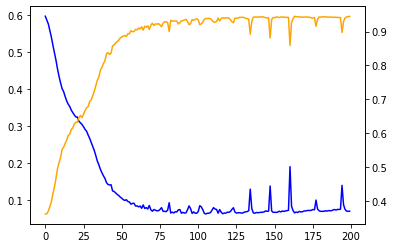

In [9]:
fig = plt.figure()
ax_loss = fig.add_subplot(1,1,1)
ax_loss.plot(range(epochs), history['valid_loss'], label='valid_loss', color='blue')
ax_acc = ax_loss.twinx()
ax_acc.plot(range(epochs), history['valid_acc'], label='valid_acc', color='orange')
plt.xlabel('epochs')
plt.show()